<a href="https://colab.research.google.com/github/ekkards/molecules/blob/master/LiH_trotter_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LiH molecule

## Origin of this method: Low rank decomposition of the Coulomb operator
 "Low rank representations for quantum simulation of electronic structure"
Mario Motta, Erika Ye, Jarrod R. McClean, Zhendong Li, Austin J. Minnich, Ryan Babbush, Garnet Kin-Lic Chan
https://arxiv.org/abs/1808.02625

The code is adapted from OpenFermion-Cirq Tutorial III: Low rank, arbitrary basis molecular simulations https://github.com/quantumlib/OpenFermion-Cirq/blob/master/examples/tutorial_3_arbitrary_basis_trotter.ipynb

In Tutorial III both of those techniques are combined, along with some insights from electronic structure,
to simulate a Trotter step under the arbitrary basis two-body operator as
$$
\prod_{\ell=0}^{L-1} R_\ell \exp\left(-i\sum_{pq} f_{\ell p} f_{\ell q} a^\dagger_p a_p a^\dagger_q a_q\right) R_\ell^\dagger
$$
where we note that the operator in the exponential take the form of a diagonal Coulomb operator. Since we can implement the $R_\ell$ circuits in $O(N)$ depth (see Tutorial I) and we can implement Trotter steps under diagonal Coulomb operators in $O(N)$ layers of gates (see Tutorial II) we see that we can implement Trotter steps under arbitrary basis electronic structure Hamiltionians in $O(L N) = O(N^2)$ depth, and all on a linearly connected device.

## Example implementation: Trotter steps of LiH in molecular orbital basis

We will now use these techniques to implement Trotter steps for an actual molecule. We will focus on LiH at equilibrium geometry, since integrals for that system are provided with every OpenFermion installation. However, by installing [OpenFermion-PySCF](https://github.com/quantumlib/OpenFermion-PySCF) or [OpenFermion-Psi4](https://github.com/quantumlib/OpenFermion-Psi4) one can use these techniques for any molecule at any geometry. We will generate LiH in an active space consisting of 4 qubits. First, we obtain the Hamiltonian as an InteractionOperator.

In [1]:
# Install required libraries in colab
!pip install openfermion
!pip install cirq
!pip install openfermioncirq

In [2]:
# Set Hamiltonian parameters for LiH simulation in active space.
import openfermion
diatomic_bond_length = 1.45
geometry = [('Li', (0., 0., 0.)), ('H', (0., 0., diatomic_bond_length))]
basis = 'sto-3g'
multiplicity = 1
active_space_start = 1
active_space_stop = 3

# Generate and populate instance of MolecularData.
molecule = openfermion.MolecularData(geometry, basis, multiplicity, description="1.45")
molecule.load()

# Get the Hamiltonian in an active space.
molecular_hamiltonian = molecule.get_molecular_hamiltonian(
    occupied_indices=range(active_space_start),
    active_indices=range(active_space_start, active_space_stop))

print("Molecular Hamiltonian with 1 constant and {} 1-body and {} 2-body tensor terms"
        .format(molecular_hamiltonian.one_body_tensor.size, 
                molecular_hamiltonian.two_body_tensor.size))

# obtain the Hamiltonian as matrix
hamiltonian_sparse = openfermion.get_sparse_operator(molecular_hamiltonian)
LiH_matrix = hamiltonian_sparse.todense()
print("Hamiltonian matrix as {} from which {} are not null"
      .format( LiH_matrix.shape, hamiltonian_sparse.nnz))

# solve for eigenvalues by matrix algorithms
from scipy.linalg import eigh
eigenvalues , eigenvectors = eigh(LiH_matrix)
print("Eigenvalues  (Energies)\n", eigenvalues.round(6))
print("Eigenvectors (Orbitals)\n", eigenvectors.real.round(1))

Molecular Hamiltonian with 1 constant and 16 1-body and 256 2-body tensor terms
Hamiltonian matrix as (16, 16) from which 36 are not null
Eigenvalues  (Energies)
 [-7.862773 -7.783396 -7.783396 -7.714057 -7.714057 -7.714057 -7.700476
 -7.569985 -7.569985 -7.512    -7.512    -7.364817 -7.151525 -7.130407
 -7.130407 -6.769813]
Eigenvectors (Orbitals)
 [[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   1. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.1  0.   0.   0.   0.   1.
   0.1  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.1 -0.   0.   0.   0.   0.  -0.1
   1.   0. ]
 [ 0.   0.  -0.   0.   0.   0.  -0.1  0.   0.  -0.  -0.   0.   1.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.1 -1.   0.   0.   0.   0.   0.1
   0.   0. ]
 [ 0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.7  0.  -0.7  0.   0.   0.   0.   0.  -0.1  0.
   0.   0. ]
 [-0.  -0.  -0.   0.   0.   0.   0.   0.   0.  -0.  -1.   

We are not yet aiming for chemical accuracy. We could check the Hamiltonian' eigenvalues with experimental data or compare to other computations from https://cccbdb.nist.gov/energy2.asp 
However, in the example the molecule integrals are provided by OpenFermion only for $1,45 \mathring{A}$. If you look up the experimental geometry (correct for the Born-Openheimer approximation), $r_{LiH} = 1.595 \mathring{A}$ for $^7Li$ https://cccbdb.nist.gov/expgeom2.asp.

You can see that the matrix calculation would result in exponential runtimes for larger systems. We convert the Hamiltonian for simulation with a quantum computer into the so-called "second quantized" operator form, as was shown in Tutorial II.
$$
H = \sum_{pq} T_{pq} a^\dagger_p a_q + \sum_{pq} V_{pq} a^\dagger_p a_p a^\dagger_q a_q.
$$

In [3]:
fermion_operator = openfermion.get_fermion_operator(molecular_hamiltonian)
print("Fermionic Hamiltonian with {} terms".format( len(fermion_operator.terms)))
#print(fermion_operator)

Fermionic Hamiltonian with 73 terms


We see from the above output that this is a fairly complex Hamiltonian already. Next we will use the `simulate_trotter` function from Tutorial I, but this time with the built-in `LOW_RANK` Trotter step type, associated with these low rank techniques.

Next we setup the simulation environment with qubits on a line.

In [4]:
import cirq
import openfermioncirq
from openfermioncirq import trotter

# Trotter step parameters.
time = 1.
final_rank = 2

# Initialize circuit qubits in a line.
n_qubits = openfermion.count_qubits(molecular_hamiltonian)
qubits = cirq.LineQubit.range(n_qubits)

In the cell below, we compile the Trotter step with full rank so $L = N^2$ and depth is actually $O(N^3)$ and repeat the Trotter step multiple times to show that it actually converges to the correct result. Note that the rank of the Coulomb operators is asymptotically $O(N)$ but for very small molecules in small basis sets only a few eigenvalues can be truncated.

In [5]:
# Trotter step paramaters.
n_steps = 3

# Compile the low rank Trotter step using OpenFermion-Cirq.
qubits = cirq.LineQubit.range(n_qubits)
circuit = cirq.Circuit(
    trotter.simulate_trotter(
            qubits, molecular_hamiltonian,
            time=time, n_steps=n_steps,
            algorithm=trotter.LOW_RANK),
    strategy=cirq.InsertStrategy.EARLIEST)

# Print circuit.
print(f'Circuit was generated with {len(circuit)} moments')
cirq.DropNegligible().optimize_circuit(circuit)
cirq.DropEmptyMoments().optimize_circuit(circuit)
print(f'After optimization, Circuit has {len(circuit)} moments')
#print(circuit.to_text_diagram(transpose=True))

Circuit was generated with 178 moments
After optimization, Circuit has 169 moments


For comparison we compute the time step with the exact time evolution operator $\psi(t) = e^{ -i H t } \psi(0)$ in matrix form.

We plot the exact values as solid lines and the simulation as dashed lines and include a global phase $e^{i\pi/2}$ for each trotter step.

time=1 fidelity=0.999998 phase=0*pi


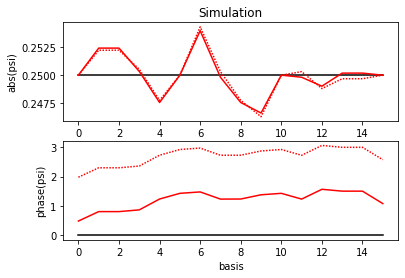

In [6]:
# Initialize a random initial state.
import math, cmath, scipy, numpy
#random_seed = 8317
#initial_state = openfermion.haar_random_vector(
#    2 ** n_qubits, random_seed).astype(numpy.complex64)

# mixed state with tensor product, equivalent to Hadamard gates
state = (1./math.sqrt(2.),1./math.sqrt(2.))
for qbit in range(1,n_qubits):
    state = numpy.kron( (1./math.sqrt(2.),1./math.sqrt(2.)), state )
initial_state = state.astype(numpy.complex64)

# or pick any eigenvector
#initial_state = eigenvectors[3]
simulator = cirq.Simulator()

# display exact vs. simulated
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
axs[1].set_xlabel('basis')
axs[0].set_ylabel('abs(psi)')
axs[1].set_ylabel('phase(psi)')
axs[0].set_title('Simulation')
color = ['k', 'r', 'g', 'b', 'c', 'm', 'y']
x = range(initial_state.size)
# start from same initial state
exact_state = initial_state
simulated_state = initial_state

phs = numpy.vectorize(cmath.phase)
axs[0].plot(x, abs(initial_state), color[0])
axs[1].plot(x, phs(initial_state), color[0])
for it in range(1,2):
  # Numerically compute the correct circuit output, solid line
  exact_state = scipy.sparse.linalg.expm_multiply(
    -1j * time * hamiltonian_sparse, initial_state)
  #phase = cmath.exp(it*1j*math.pi/2)    # needed for plot, may be off
  axs[0].plot(x, abs(exact_state), color[it])
  axs[1].plot(x, phs(exact_state), color[it])

  # Use Cirq simulator to apply circuit, dotted line

  result = simulator.simulate(circuit, qubit_order=qubits, initial_state=simulated_state)
  simulated_state = result.final_state
  axs[0].plot(x, abs(simulated_state), color[it], dashes=[1, 1])
  axs[1].plot(x, phs(simulated_state), color[it], dashes=[1, 1])

  # Print fidelity and phase
  ab, ph = cmath.polar(numpy.dot(simulated_state,numpy.conjugate(exact_state)))
  print('time={} fidelity={} phase={}*pi'
    .format(it, round(ab**2,6),round(ph/math.pi)))
plt.show()

Now run like on a quantum computer , which needs preparation of initial state by gates and has a measurement at the very end:

Sample the circuit:


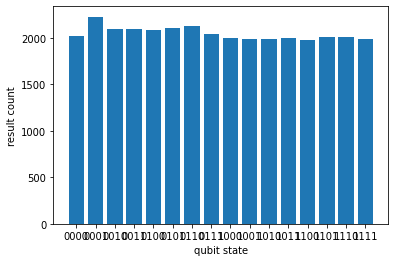

In [7]:
circuit.insert(0,(cirq.H(q) for q in qubits))   # Hadamard gate for equal distribution
circuit.append(cirq.measure_each(*qubits) )
#print(circuit)
print('Sample the circuit:')
samples=simulator.run(circuit, repetitions=32768)
#counts = samples.multi_measurement_histogram(keys=qubits)
from cirq.study import visualize
arr = visualize.plot_state_histogram(samples)
